## Product Recommendation Based on Image Similarity

- Used a pre-trained CNN model from Keras to extract the image features. 
- Then computed similarities between the different products using the previously extracted image features.

<img src="../reference/awswebsite.png" width=500 align="center"> 

In [1]:
# !pip install keras

In [2]:
# !pip install tensorflow==2.0.0-alpha0 

In [4]:
# !pip install ipython-autotime

### Import libraries

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
from keras.models import Model
from keras.applications import vgg16
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autotime

Using TensorFlow backend.


### Set parameters

In [8]:
# Set variables.
imgs_path = "./Images_50K/"
imgs_model_width, imgs_model_height = 224, 224 # Image size 
num_closest_images = 5 # number of most similar product to retrieve

time: 1.11 ms


### Data Processing 

In [9]:
# Get all image files. 
image_files = [imgs_path + pic for pic in os.listdir(imgs_path) if "jpg" in pic]
print("Number of images:",len(image_files))

Number of images: 4249
time: 5.75 ms


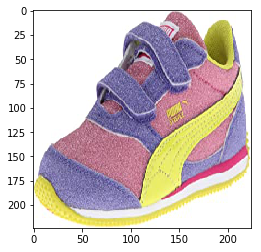

time: 702 ms


In [10]:
#Show onevimages.
original = load_img(image_files[10], target_size=(224,224))
plt.imshow(original)
plt.show()

In [11]:
# Get all product asins.
productIds = []
for file in image_files:
    base = os.path.basename(file)
    asin = os.path.splitext(base)[0]
    productIds.append(asin)
print("Number of productIds:",len(productIds))

Number of productIds: 4249
time: 12.5 ms


In [13]:
# Get image urls and save as dictionary. {asin: image_url}
imgUrl_df = pd.read_csv('./asin_url_for_50k.csv')
imgUrl_dict = pd.Series(imgUrl_df.url.values,index=imgUrl_df.asin).to_dict()

time: 20.4 ms


### Load the VGG pre-trained model from Keras

Loaded the VGG16 model trained on imagenet, a big labeled images database. If we take the whole model, we will get an output containing probabilities to belong to certain classes,so removed the last layers of the CNN which are only used for classes predictions.

<img src="../reference/cnnLayers.png" width="400"> 

In [14]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()


553467904/553467096 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

### Feed one image into CNN.

In [15]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
original = load_img(image_files[10], target_size=(224,224))
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('Image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

Image batch size (1, 224, 224, 3)
time: 7.19 ms


In [16]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("Features successfully extracted!")
print("Number of image features:",img_features.size)


Features successfully extracted!
Number of image features: 4096
time: 1.14 s


### Feed all images into CNN

In [17]:
# load all the images and prepare them for feeding into the CNN
ImageFile.LOAD_TRUNCATED_IMAGES = True
importedImages = []

for file in image_files:
    filename = file
    original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

time: 18.7 s


### Extract the image fetures. (saved as csv file)

In [ ]:
# Extract the images features.
imgs_features = feat_extractor.predict(processed_imgs)

print("Features successfully extracted!")
print("Size of feature dataset:", imgs_features.shape)

In [40]:
# Convert to DataFrame.
features_df = pd.DataFrame(data=imgs_features, index=productIds, columns=range(4096))
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
B008JFDFIW,0.0,0.0,1.847189,2.641750,0.0,0.000000,0.000000,6.623529,0.0,0.000000,...,0.0,0.0,0.0,1.501545,0.0000,0.000000,0.0,0.0,0.0,1.291022
B00IM5FCOY,0.0,0.0,0.164301,0.000000,0.0,1.673070,0.000000,0.000000,0.0,6.619954,...,0.0,0.0,0.0,0.000000,0.0000,5.276841,0.0,0.0,0.0,0.000000
B00AAHNZUU,0.0,0.0,0.000000,0.855917,0.0,0.000000,0.000000,0.000000,0.0,3.871443,...,0.0,0.0,0.0,0.000000,1.8203,4.572748,0.0,0.0,0.0,0.000000
B004J4WWK4,0.0,0.0,0.000000,0.000000,0.0,3.584921,0.000000,0.000000,0.0,1.201754,...,0.0,0.0,0.0,0.000000,0.0000,6.192037,0.0,0.0,0.0,0.000000
B000BIUAYW,0.0,0.0,0.000000,4.482935,0.0,0.000000,2.517327,0.000000,0.0,3.512050,...,0.0,0.0,0.0,3.508799,0.0000,0.000000,0.0,0.0,0.0,1.227973


time: 28.5 ms


In [41]:
features_df.shape

(4249, 4096)

time: 3.23 ms


In [83]:
# Save as a csv file.
features_df.to_csv('./features_50k.csv')

time: 14.6 s


### Calculate cosine similarities.

In [43]:
# compute cosine similarities between images
cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=productIds, index=productIds)
cos_similarities_df.head()

,B008JFDFIW,B00IM5FCOY,B00AAHNZUU,B004J4WWK4,B000BIUAYW,B00GUV6U1Q,B009HGDS9I,B00026ORRY,B000I66VSG,B00DX9TEAM,...,B00JWY671G,B00NCPIE9Y,B00193SGBC,B000H73YM2,B0002UNNTS,B001CDJXC0,B00NC4F22C,B001OW6T12,B000AJHWCA,B0010T46LE
B008JFDFIW,1.000000,0.362864,0.308780,0.417288,0.432381,0.685618,0.234785,0.457745,0.516445,0.417970,...,0.425732,0.407043,0.460005,0.455167,0.396222,0.502779,0.670686,0.447899,0.268567,0.501026
B00IM5FCOY,0.362864,1.000000,0.360608,0.665956,0.301227,0.437460,0.183060,0.542963,0.350693,0.479026,...,0.340522,0.473009,0.591870,0.527000,0.392424,0.298348,0.469669,0.457021,0.786262,0.404387
B00AAHNZUU,0.308780,0.360608,1.000000,0.375854,0.498847,0.279762,0.208102,0.300166,0.393287,0.375296,...,0.461527,0.270608,0.309120,0.300027,0.436809,0.303264,0.324404,0.293918,0.346671,0.332892
B004J4WWK4,0.417288,0.665956,0.375854,1.000000,0.315326,0.531801,0.217042,0.701494,0.546180,0.544264,...,0.385281,0.528229,0.564211,0.552363,0.486948,0.499572,0.412053,0.553167,0.684340,0.519154
B000BIUAYW,0.432381,0.301227,0.498847,0.315326,1.000000,0.450696,0.291314,0.341520,0.506457,0.488138,...,0.619143,0.374053,0.371834,0.391754,0.540534,0.400048,0.425884,0.353776,0.304871,0.390239


time: 744 ms


### Retrieve the top 5 most similar products 

In [74]:
def retrieve_most_similar_products(given_img,num_closest_images):
    
    base=os.path.basename(given_img)
    asin = os.path.splitext(base)[0]

    print("-----------------------------------------------------------------------")
    print("original product:",asin)

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(original)
    plt.show()
   
    
    
    
    print("-----------------------------------------------------------------------")
    print("most similar products:")
    
    base = os.path.basename(given_img)
    given_asin = os.path.splitext(base)[0]
    
    # Sort product by similarity score. 
    sorted_cos_similarities = cos_similarities_df[given_asin].sort_values(ascending=False)
    
    # Drop duplicated similarity score.
    sorted_cos_similarities = sorted_cos_similarities.drop_duplicates(keep='first', inplace=False)
    
    # select similiarty score not equal to 1. 
    sorted_cos_similarities = sorted_cos_similarities[sorted_cos_similarities < 0.95]
    
    # Get asin & score. 
    closest_imgs = sorted_cos_similarities[1:num_closest_images+1].index
    closest_imgs_scores = sorted_cos_similarities[1:num_closest_images+1]

    # Plot
    for i in range(0,len(closest_imgs)):
        asin = closest_imgs[i]
        dir_name = './Images_50K/'
        file_path = os.path.join(dir_name, asin + ".jpg" )
        original = load_img(file_path, target_size=(imgs_model_width, imgs_model_height))
        plt.figure(figsize=(2,2))
        plt.axis('off')
        plt.imshow(original)
        plt.show()

        print("product ID:",asin)
        print("similarity score : ",closest_imgs_scores[i])

time: 5.01 ms


-----------------------------------------------------------------------
original product: B0009BASN4


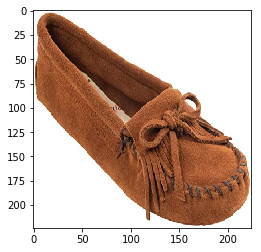

-----------------------------------------------------------------------
most similar products:


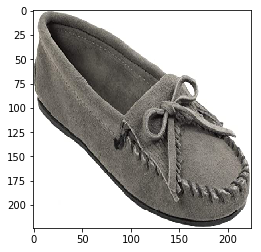

product ID: B0039YPD74
similarity score :  0.8495926


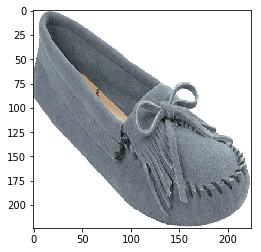

product ID: B0009DI4N8
similarity score :  0.8317559


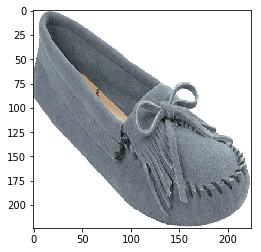

product ID: B0009C7NI6
similarity score :  0.8317558


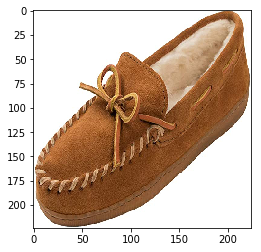

product ID: B0009IU81O
similarity score :  0.8171632


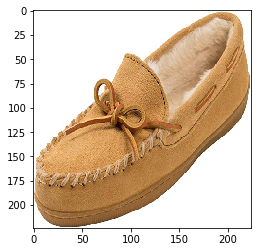

product ID: B0009IZWII
similarity score :  0.80046904
time: 1.12 s


In [75]:
retrieve_most_similar_products(given_img=image_files[30], num_closest_images=5)

### Retrieve the top 5 most similar products for ALL products.(saved as csv file)

In [76]:
# Create an emply dataframe with given column names.
# column_names = ["given_product", "given_product_img_url", \
#                 "recommended_product", "recommended_product_img_url",\
#                 "similarity_score"]

# recommeded_df = pd.DataFrame(columns = column_names)

time: 5.8 ms


In [79]:
def GetALLRecommenedProduct(productIds,num_closest_images):
    
    # Create an emply dataframe with given column names.
    
    column_names = ["given_product", "given_product_img_url", \
                "recommended_product", "recommended_product_img_url",\
                "similarity_score"]

    recommeded_df = pd.DataFrame(columns = column_names) 
    
    for product in productIds:
        
        # Sort product by similarity score. 
        sorted_cos_similarities = cos_similarities_df[product].sort_values(ascending=False)
    
        # Drop duplicated similarity score.
        sorted_cos_similarities = sorted_cos_similarities.drop_duplicates(keep='first', inplace=False)
    
        # select similiarty score less than 0.95. 
        sorted_cos_similarities = sorted_cos_similarities[sorted_cos_similarities < 0.95]
                
        asins = list(sorted_cos_similarities.index)
        scores = list(sorted_cos_similarities.values)
        for i in range(num_closest_images):
            new_row = {"given_product":product, "given_product_img_url": imgUrl_dict[product],\
                       "recommended_product": asins[i], "recommended_product_img_url": imgUrl_dict[asins[i]],\
                       "similarity_score": scores[i]}
            
            recommeded_df = recommeded_df.append(new_row, ignore_index=True)
            
    return recommeded_df
        

time: 4.08 ms


In [80]:
recommeded_df = GetALLRecommenedProduct(productIds,num_closest_images)
# recommeded_df.head()

time: 1min 24s


In [82]:
# Save as a csv file.
recommeded_df.to_csv('./RESULT_image_recommended_product_50k.csv',index=False)

time: 140 ms


In [173]:
recommeded_df.head()

,given_product,given_product_img_url,recommended_product,recommended_product_img_url,similarity_score
0,B008JFDFIW,https://images-na.ssl-images-amazon.com/images...,B0083G67YQ,https://images-na.ssl-images-amazon.com/images...,0.838889
1,B008JFDFIW,https://images-na.ssl-images-amazon.com/images...,B004G604D2,https://images-na.ssl-images-amazon.com/images...,0.815943
2,B008JFDFIW,https://images-na.ssl-images-amazon.com/images...,B00AF6T5FA,https://images-na.ssl-images-amazon.com/images...,0.806498
3,B008JFDFIW,https://images-na.ssl-images-amazon.com/images...,B008YU35P0,https://images-na.ssl-images-amazon.com/images...,0.798550
4,B008JFDFIW,https://images-na.ssl-images-amazon.com/images...,B004MY6ASQ,https://images-na.ssl-images-amazon.com/images...,0.796886


time: 10.4 ms
